In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

c:\Users\luisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoder = tf.keras.models.load_model('../Guilherme/modelos/RBBB/autoencoder_model_V1V6RBBB.keras')

In [3]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                   "exams_part2.hdf5", "exams_part3.hdf5", "exams_part4.hdf5", "exams_part5.hdf5",
                   "exams_part6.hdf5", "exams_part7.hdf5", "exams_part8.hdf5", "exams_part9.hdf5",
                   "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                   "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == 1) & 
                                (dados.iloc[:, 6] == 0) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 0)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ids_proibidos = [ 227806,
187353,
203399,
343089,
317296,
260982 ]

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) & ~dados['exam_id'].isin(ids_proibidos)]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == 1) & 
                                (dados.iloc[:, 6] == 0) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == 0) & 
                                (dados.iloc[:, 9] == 0)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:20000]

ids_ecgs= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 134657
Número de linhas ecg_doente_linhas: 7685
Tirando Interferência:
Número de linhas ecg_normal_linhas: 130871
Número de linhas ecg_doente_linhas: 7566
Número de ecgs pra clusterizar: 27566


In [4]:
#X
arquivos_hdf5 = ["../Database/filtered_exams_0_1.hdf5",
                 "../Database/filtered_exams_2_3.hdf5",  "../Database/filtered_exams_4_5.hdf5",
                 "../Database/filtered_exams_6_7.hdf5",  "../Database/filtered_exams_8_9.hdf5",
                 "../Database/filtered_exams_10_11.hdf5",  "../Database/filtered_exams_12_13.hdf5",
                 "../Database/filtered_exams_14_15.hdf5", "../Database/filtered_exams_16_17.hdf5"]

# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(arquivos_hdf5, exam_id)
    # Selecionar as leads V1 (índice 6) e V6 (índice 11)tracings = get_ecg_data(arquivos_hdf5, exam_id)
    # DI, DII, DIII, AVL, AVF, AVR, V1, V2, V3, V4, V5, V6
    #lead_d1 = tracings[:, 0]
    #lead_d2 = tracings[:, 1]
    #lead_d3 = tracings[:, 2]
    #lead_avl = tracings[:, 3]
    #lead_avf = tracings[:, 4]
    #lead_avr = tracings[:, 5]
    lead_v1 = tracings[:, 6]
    #lead_v2 = tracings[:, 7]
    #lead_v3 = tracings[:, 8]
    #lead_v4 = tracings[:, 9]
    #lead_v5 = tracings[:,10]
    lead_v6 = tracings[:,11]
    #Combinar as leads V1 e V6 em uma única dimensão 
    combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(combined_leads)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)

Shape de X para o autoencoder: (27566, 8192)


In [12]:
#X SE VC ESTIVER NA GÓRGONA
arquivos_hdf5 = ['../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5', '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5', 
              '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5', '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5',
              '../../../../pedro.bacelar/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5', '../../../../ecg_clustering/Database_Filtrados/filtered_exams_0_1.hdf5'] # Caminhos para os arquivos HDF5

# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(arquivos_hdf5, exam_id)
    # Selecionar as leads V1 (índice 6) e V6 (índice 11)tracings = get_ecg_data(arquivos_hdf5, exam_id)
    # DI, DII, DIII, AVL, AVF, AVR, V1, V2, V3, V4, V5, V6
    #lead_d1 = tracings[:, 0]
    #lead_d2 = tracings[:, 1]
    #lead_d3 = tracings[:, 2]
    #lead_avl = tracings[:, 3]
    #lead_avf = tracings[:, 4]
    #lead_avr = tracings[:, 5]
    lead_v1 = tracings[:, 6]
    #lead_v2 = tracings[:, 7]
    #lead_v3 = tracings[:, 8]
    #lead_v4 = tracings[:, 9]
    #lead_v5 = tracings[:,10]
    lead_v6 = tracings[:,11]
    #Combinar as leads V1 e V6 em uma única dimensão 
    combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(combined_leads)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)

Shape de X para o autoencoder: (27566, 8192)


In [5]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

epsilon = 1e-10

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

# Substituir os valores NaN por epsilon
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

epsilon = 1e-10
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

C:\Users\luisa\AppData\Local\Temp\ipykernel_23016\144704460.py:9: RuntimeWarning: invalid value encountered in divide
  X = X / np.max(np.abs(X), axis=1, keepdims=True)


862/862 ━━━━━━━━━━━━━━━━━━━━ 126s 146ms/step
(27566, 128, 1)
(27566, 128)


In [6]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=7, min_dist=0.0, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

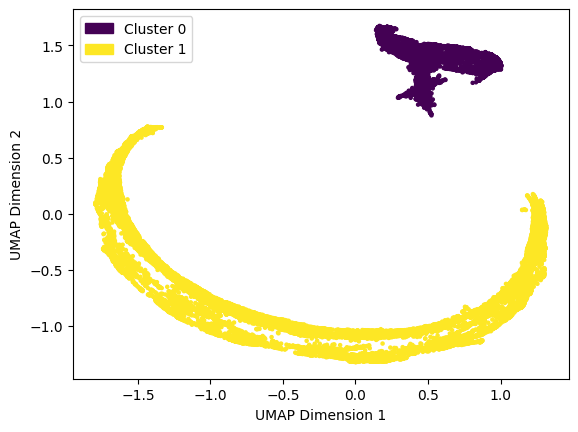

Silhouette Score: 0.1885671317577362


C:\Users\luisa\AppData\Local\Temp\ipykernel_23016\2108103736.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


F1 Score: 0.8045416697889248
   cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0        0      0  7171     0   0   0   0         898
1        1      0   395     0   0   0   0       19102


In [7]:
#CLUSTERIZACAO HDBSCAN DA GORGONA

from sklearn.metrics import silhouette_score, f1_score
from hdbscan import HDBSCAN

exam_ids_to_cluster = ids_ecgs  

scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=2000, min_samples=1 )
labels = dbscan.fit_predict(X_reduced_scaled)

# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=5)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
import matplotlib.patches as mpatches
cluster_0_patch = mpatches.Patch(color=plt.cm.viridis(0.0), label='Cluster 0')
cluster_1_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label='Cluster 1')
plt.legend(handles=[cluster_0_patch, cluster_1_patch], loc='best')
plt.savefig('RBBB.jpg')
plt.show()

# Calcular e imprimir os scores
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, labels, average='weighted')
print(f'F1 Score: {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

C:\Users\luisa\AppData\Local\Temp\ipykernel_23016\390473447.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1],  c=[color_map[label] for label in labels], cmap='viridis', s=1)


Silhouette Score: 0.1885671317577362


C:\Users\luisa\AppData\Local\Temp\ipykernel_23016\390473447.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


F1 Score: 0.8045416697889248
   cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0        0      0  7171     0   0   0   0         898
1        1      0   395     0   0   0   0       19102


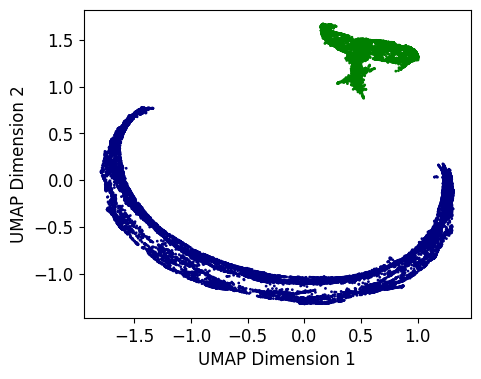

In [28]:
#CLUSTERIZACAO HDBSCAN LUISA (DO PAPER)

from sklearn.metrics import silhouette_score, f1_score
from hdbscan import HDBSCAN

exam_ids_to_cluster = ids_ecgs  

scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=2000, min_samples=1 )
labels = dbscan.fit_predict(X_reduced_scaled)

doenca ='RBBB'

# Visualização dos Resultados com Outliers Reagrupados
color_map = {0: 'green', 1: 'navy'}
plt.figure(figsize=(5, 4))
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1],  c=[color_map[label] for label in labels], cmap='viridis', s=1)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)  # Aumenta o tamanho dos números dos eixos

import matplotlib.patches as mpatches
cluster_0_patch = mpatches.Patch(color='red', label='Cluster 0')
cluster_1_patch = mpatches.Patch(color='navy', label='Cluster 1')
#plt.legend(handles=[cluster_0_patch, cluster_1_patch], loc='best')
plt.savefig(f'../Imagens/{doenca}.png', dpi=1000, bbox_inches='tight', pad_inches=0.1)


# Calcular e imprimir os scores
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, labels, average='weighted')
print(f'F1 Score: {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

In [11]:
# CALCULAR SILIHUETTE SCORE POR CLUSTER

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score, f1_score, pairwise_distances

new_labels = labels

# Usar apenas as duas primeiras dimensões
X_reduced_2d = X_reduced_scaled[:, :2]

# Calcular o Silhouette Score médio
silhouette_avg = silhouette_score(X_reduced_2d, new_labels)
print(f'Silhouette Score médio (2D): {silhouette_avg}')

# Calcular o Silhouette Score para cada ponto
silhouette_values = silhouette_samples(X_reduced_2d, new_labels)

# Número de clusters encontrados
n_clusters = len(set(new_labels)) - (1 if -1 in new_labels else 0)

# Criar um DataFrame para os silhouette scores
silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': new_labels,
    'silhouette_score': silhouette_values
})

# Calcular o Silhouette Score médio para cada cluster separado
cluster_silhouette_avg = silhouette_df.groupby('cluster')['silhouette_score'].mean()
print("\nSilhouette Score médio por cluster (2D):")
print(cluster_silhouette_avg)

Silhouette Score médio (2D): 0.5035590529441833

Silhouette Score médio por cluster (2D):
cluster
0    0.843585
1    0.362837
Name: silhouette_score, dtype: float32


In [12]:
# CALCULAR SILHUETT DE CADA PONTO

from sklearn.metrics import silhouette_samples

silhouette_values = 0
silhouette_values = silhouette_samples(X_reduced_scaled, labels)

silhouette_df = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'label': labels,
    'silhouette_score': silhouette_values
})

merged_data = silhouette_df.merge(metadata, on='exam_id')

In [13]:
# GERAR CSV RESULTADOS

# GUARDAR EM CSVS

doenca = 'RBBB'

colunas_desejadas = ['exam_id', 'label', '1dAVb', 'RBBB', 'LBBB' , 'SB' ,'ST' , 'AF', 'normal_ecg', 'silhouette_score']
dados = merged_data[colunas_desejadas]
dados = dados.sort_values(by=['label', 'silhouette_score'], ascending=[True, False])

conditions = [
    (dados['label'] == 0) & (dados[doenca] == True), (dados['label'] == 0) & (dados[doenca] == False),
    (dados['label'] == 1) & (dados[doenca] == True), (dados['label'] == 1) & (dados[doenca] == False),
    (dados['label'] == 2) & (dados[doenca] == True), (dados['label'] == 2) & (dados[doenca] == False),
    (dados['label'] == -1) & (dados[doenca] == True), (dados['label'] == -1) & (dados[doenca] == False)
]
choices = [
    'D_clusterD', 'N_clusterD',
    'D_clusterN','N_clusterN',
    'D_clusterM','N_clusterM',
    'D_clusterO','N_clusterO',
]

dados['tipo'] = np.select(conditions, choices, default='Unknown')

dados.to_csv(f'resultados/{doenca}.csv', index=False)

In [ ]:
# SELECIONANDO MAIS DOENTES NO CLUSTER NORMAL

tipos_desejados = ['D_clusterN']
quantidade = 20

def select_evenly_spaced(df, quantidade=quantidade):
    total_rows = len(df)
    if total_rows <= quantidade:
        return df
    else:
        indices = np.linspace(0, total_rows-1, quantidade, dtype=int)
        return df.iloc[indices]

ja_vistos = pd.read_csv(f'resultados/{doenca}.csv')
ids_proibidos = ja_vistos[ja_vistos['tipo'] == 'D_clusterN']['exam_id'].tolist()

dados = dados[dados['tipo'].isin(tipos_desejados)]

dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced)

dados_selecionados = dados_selecionados[~dados_selecionados['exam_id'].isin(ids_proibidos)]

while len(dados_selecionados) < quantidade:
    dados_necessarios = quantidade - len(dados_selecionados)
    outros_dados = dados[~dados['exam_id'].isin(ids_proibidos)]
    adicionais = outros_dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced, quantidade=dados_necessarios)
    dados_selecionados = pd.concat([dados_selecionados, adicionais]).drop_duplicates(subset='exam_id')
    ids_proibidos = dados_selecionados['exam_id'].tolist()

dados_selecionados = dados_selecionados[dados_selecionados['tipo'].isin(tipos_desejados)]

if len(dados_selecionados) < quantidade:
    raise ValueError(f"Não foi possível obter {quantidade} amostras do tipo 'D_clusterN'.")

dados_selecionados.to_csv(f'maisAmostras_d_n/{doenca}_amostras.csv', index=False)


C:\Users\luisa\AppData\Local\Temp\ipykernel_24592\2407590582.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_evenly_spaced)


C:\Users\luisa\AppData\Local\Temp\ipykernel_24592\1548981925.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_25_evenly_spaced)


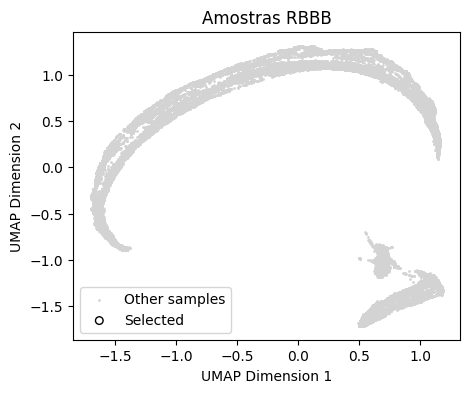

In [ ]:
# GERAR AMOSTRAS

def select_25_evenly_spaced(df):
    total_rows = len(df)
    if total_rows <= 25:
        return df
    else:
        indices = np.linspace(0, total_rows-1, 45, dtype=int)
        return df.iloc[indices]
    
dados_selecionados = dados.groupby('tipo', group_keys=False).apply(select_25_evenly_spaced)

tipos_desejados = ['D_clusterD']
dados_selecionados = dados_selecionados[dados_selecionados['tipo'].isin(tipos_desejados)]

dados_selecionados.to_csv(f'amostras/{doenca}_amostras.csv', index=False)

#PLOTAR AMOSTRAS

def plot_samples(X, exam_ids, labels, title):
    colors = ['gray',    # 0: Other samples
              'yellow',  # 1: D_clusterN
              'orange',  # 2: N_clusterD
              'blue',    # 3: D_clusterM
              'red',     # 4: N_clusterM
              'purple',  # 5: D_clusterO
              'green']   # 6: N_clusterO
    exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
    sample_indices = [exam_id_to_index[exam_id] for exam_id in exam_ids]

    all_labels = np.zeros(X.shape[0])
    all_labels[sample_indices] = labels

    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=1, label='Other samples')
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], c=[colors[label] for label in labels], s=30, edgecolor='k', label='Selected')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title(title)
    plt.legend()
    plt.show()

selected_exam_ids = dados_selecionados['exam_id'].values

exam_id_to_index = {exam_id: idx for idx, exam_id in enumerate(exam_ids_to_cluster)}
selected_indices = [exam_id_to_index[exam_id] for exam_id in selected_exam_ids]

labels = [
    1 if tipo == 'D_clusterN' else 2 if tipo == 'N_clusterD' else
    3 if tipo == 'D_clusterM' else 4 if tipo == 'N_clusterM' else
    5 if tipo == 'D_clusterO' else 6 if tipo == 'N_clusterO' else 0
    for tipo in dados_selecionados['tipo'].values
]

plot_samples(X_reduced_scaled, selected_exam_ids, labels, f'Amostras {doenca}')

In [8]:
#METRICA DBCV
from sklearn.metrics import silhouette_score, f1_score, pairwise_distances_argmin_min
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from scipy.spatial.distance import euclidean
import dbcv

score = dbcv.dbcv(X_reduced_scaled, labels)
print(score)

0.9699320586963142
